In [17]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

In [2]:
df = pd.read_pickle('updated_dataframe.pkl')
df.head(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,Overall Scores,Safety and Security,Ongoing Conflict,Militarian,cleaned_speech,sentiment_score,peace_term_count,conflict_term_count,Region,sentiment_score_rolling
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,...,1.896,3.372,3.153,2.594,since last time gathered great hall passed yea...,0.9990,0,14,Asia,0.999000
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,...,1.765,3.603,3.246,2.609,first would like congratulate excellency mr tr...,0.9965,0,4,Asia,0.997750
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,...,1.838,3.549,3.087,2.629,join previous speakers congratulating sir elec...,0.9585,0,18,Asia,0.984667
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,...,1.874,3.549,3.038,2.555,honoured read statement president excellency h...,0.9899,0,16,Asia,0.985975
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,...,1.816,3.593,3.069,2.693,speak today shaken depravity fanatics committe...,-0.9661,0,17,Asia,0.595560


In [10]:
selected_features = ['Log GDP per capita', 'Life Ladder', 'Social support', 
                     'Freedom to make life choices', 'Militarian', 
                     'sentiment_score_rolling']


X = df[selected_features].dropna()
y = df.loc[X.index, 'Overall Scores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
mean_r2_score = np.mean(cv_r2_scores)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_test = model.score(X_test, y_test)

print(f"Mean R² score (cross-validated on training set): {mean_r2_score:.3f}")
print(f"R² score on test set: {r2_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse:.3f}")


Mean R² score (cross-validated on training set): 0.619
R² score on test set: 0.545
Mean Squared Error (MSE) on test set: 0.068


In [27]:
# Define your list of possible features (excluding 'sentiment_score_rolling' to add it explicitly in combinations)
features = ['Log GDP per capita', 'Life Ladder', 'Healthy life expectancy at birth', 
                     'Social support', 'Freedom to make life choices', 'Militarian', 
                     'sentiment_score_rolling']

# Always include 'sentiment_score_rolling'
base_feature = ['sentiment_score_rolling']

# Function to calculate adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Function to get the adjusted R² score for a set of features
def get_adjusted_r2_score(X, y, selected_features):
    X_selected = X[selected_features].dropna()
    y_selected = y.loc[X_selected.index]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    # R² score
    r2_test = model.score(X_test, y_test)

    # Calculate adjusted R²
    n = len(y_test)
    p = len(selected_features)
    adj_r2_test = adjusted_r2(r2_test, n, p)
    
    return adj_r2_test, r2_test

# Iterate over all possible combinations of features
results = []
for i in range(1, len(features) + 1):
    for combination in itertools.combinations(features, i):
        selected_features = base_feature + list(combination)
        adj_r2, r2 = get_adjusted_r2_score(df, df['Overall Scores'], selected_features)
        results.append({
            'features': selected_features,
            'R²': r2,
            'Adjusted R²': adj_r2
        })

# Sort results by Adjusted R²
results_sorted = sorted(results, key=lambda x: x['Adjusted R²'], reverse=True)

# Print the top 5 combinations
for result in results_sorted[:5]:
    print(f"Features: {result['features']}, R²: {result['R²']:.3f}, Adjusted R²: {result['Adjusted R²']:.3f}")


Features: ['sentiment_score_rolling', 'Log GDP per capita', 'Life Ladder', 'Healthy life expectancy at birth', 'Militarian'], R²: 0.643, Adjusted R²: 0.638
Features: ['sentiment_score_rolling', 'Log GDP per capita', 'Life Ladder', 'Healthy life expectancy at birth', 'Militarian', 'sentiment_score_rolling'], R²: 0.643, Adjusted R²: 0.637
Features: ['sentiment_score_rolling', 'Log GDP per capita', 'Life Ladder', 'Militarian'], R²: 0.640, Adjusted R²: 0.636
Features: ['sentiment_score_rolling', 'Log GDP per capita', 'Life Ladder', 'Militarian', 'sentiment_score_rolling'], R²: 0.640, Adjusted R²: 0.635
Features: ['sentiment_score_rolling', 'Log GDP per capita', 'Healthy life expectancy at birth', 'Militarian'], R²: 0.632, Adjusted R²: 0.628


In [16]:
# Define the selected features
selected_features = ['sentiment_score_rolling', 'Life Ladder', 'Ongoing Conflict']

# Prepare the data
X = df[selected_features].dropna()
y = df.loc[X.index, 'Overall Scores']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the linear regression model
model = LinearRegression()

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
mean_r2_score = np.mean(cv_r2_scores)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2_test = model.score(X_test, y_test)

# Output the results
print(f"Mean R² score (cross-validated on training set): {mean_r2_score:.3f}")
print(f"R² score on test set: {r2_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse:.3f}")


Mean R² score (cross-validated on training set): 0.814
R² score on test set: 0.806
Mean Squared Error (MSE) on test set: 0.034


RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

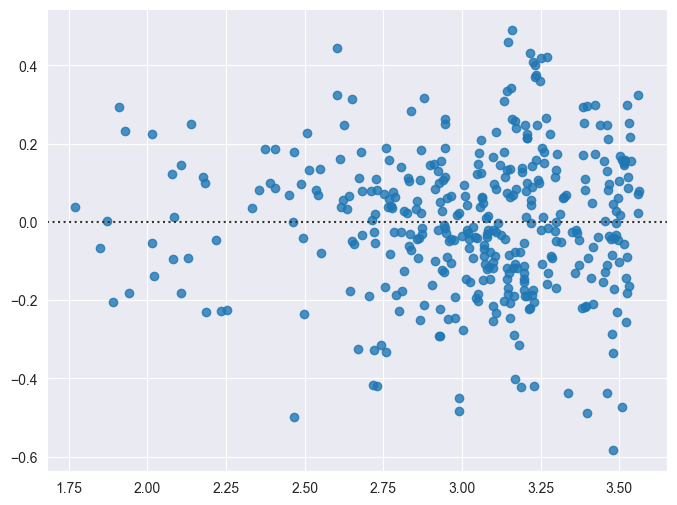

In [20]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Define the features and target variable
X = df[['sentiment_score_rolling', 'Life Ladder', 'Ongoing Conflict']].dropna()
y = df.loc[X.index, 'Overall Scores']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge regression with hyperparameter tuning
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

# Lasso regression with hyperparameter tuning
lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Evaluate Ridge and Lasso on test set
ridge_best = ridge_cv.best_estimator_
lasso_best = lasso_cv.best_estimator_

ridge_test_r2 = ridge_best.score(X_test, y_test)
lasso_test_r2 = lasso_best.score(X_test, y_test)

print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Ridge R² on test set: {ridge_test_r2:.3f}")
print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Lasso R² on test set: {lasso_test_r2:.3f}")


Best Ridge alpha: 1
Ridge R² on test set: 0.806
Best Lasso alpha: 0.01
Lasso R² on test set: 0.798


RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

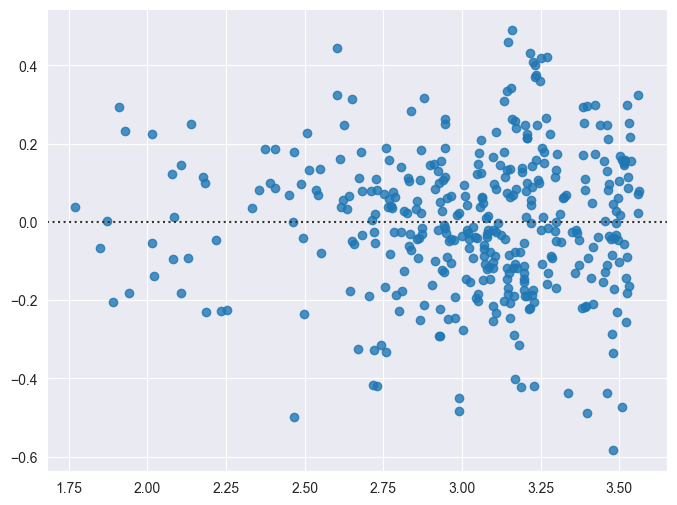

In [25]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_forest = forest_model.predict(X_test)

# Evaluate the model
r2_forest = forest_model.score(X_test, y_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)

print(f"Random Forest R² on test set: {r2_forest:.3f}")
print(f"Random Forest MSE on test set: {mse_forest:.3f}")


Random Forest R² on test set: 0.847
Random Forest MSE on test set: 0.027


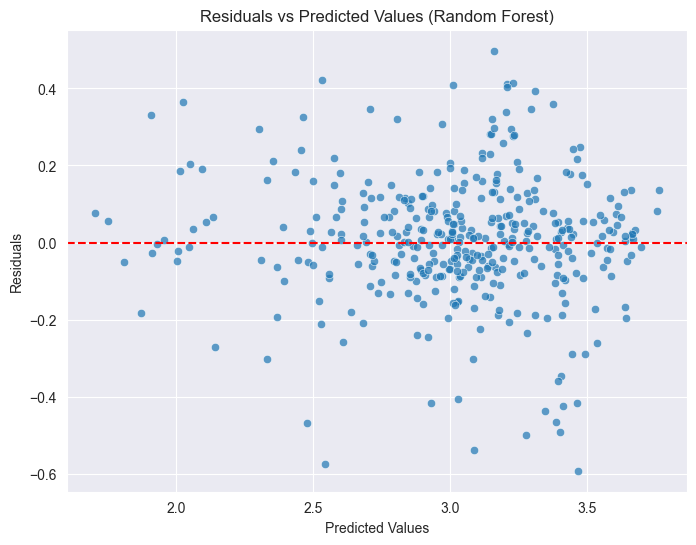

In [24]:
# Predict on the test set
y_pred_forest = forest_model.predict(X_test)

# Calculate residuals
residuals_forest = y_test - y_pred_forest

# Create the residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_forest, y=residuals_forest, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values (Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
